# Generate tile index 

In [91]:
import requests
from requests.auth import HTTPBasicAuth
import numpy as np
import json
import requests
import mercantile
import numpy as np
import datetime
from datetime import date
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("darkgrid")

In [2]:
PL_API_KEY = "41321948d404418e94a751df82f7859c"
aoi_url = "https://8ib71h0627.execute-api.us-east-1.amazonaws.com/v1/sites"

In [3]:
def get_sites(url):
    geojson = requests.get(url).json()

    features = [
        {
            'type': 'Feature',
            'geometry': site["polygon"],
            'bbox': site["bounding_box"],
            'properties': {"id": site["id"], "label": site["label"]}
        }
        for site in geojson["sites"]
    ]

    geojson = {
        "type": "FeatureCollection",
        "features": features}
    return geojson


In [4]:
def stats(geometry, collections, start_date, end_date, cc):
    """Retrieve Stats
    
    ----
    Args:
        collections: ['PSOrthoTile', 'REOrthoTile', 'PSScene3Band', 'PSScene4Band', 'SkySatScene']
        geometry: geojson for the sites
        start_date: "2020-04-01T00:00:00.000Z"
        end_date: same format as start_date
        cc: cloud cover in 0.05 (5%)
    """
    # filter for items the overlap with our chosen geometry
    geometry_filter = {
      "type": "GeometryFilter",
      "field_name": "geometry",
      "config": geometry
    }

    # filter images acquired in a certain date range
    date_range_filter = {
      "type": "DateRangeFilter",
      "field_name": "acquired",
      "config": {
        "gte": start_date,
        "lte": end_date
      }
    }

    # filter any images which are more than 50% clouds
    cloud_cover_filter = {
      "type": "RangeFilter",
      "field_name": "cloud_cover",
      "config": {
        "lte": cc
      }
    }

    config = {
      "type": "AndFilter",
      "config": [geometry_filter, cloud_cover_filter, date_range_filter]
    }
    
    # Stats API request object
    stats_endpoint_request = {
      "interval": "day", "item_types": collections, "filter": config
    }

    # fire off the POST request
    result = requests.post('https://api.planet.com/data/v1/stats', auth=HTTPBasicAuth(PL_API_KEY, ''), json=stats_endpoint_request)
    return result.json()


def search(geometry, collections, start_date, end_date, cc):
    """Search for Data."""
    # filter for items the overlap with our chosen geometry
    geometry_filter = {
      "type": "GeometryFilter",
      "field_name": "geometry",
      "config": geometry
    }

    # filter images acquired in a certain date range
    date_range_filter = {
      "type": "DateRangeFilter",
      "field_name": "acquired",
      "config": {
        "gte": start_date,
        "lte":end_date
      }
    }

    # filter any images which are more than 50% clouds
    cloud_cover_filter = {
      "type": "RangeFilter",
      "field_name": "cloud_cover",
      "config": {
        "lte": cc
      }
    }

    config = {
      "type": "AndFilter",
      "config": [geometry_filter, cloud_cover_filter, date_range_filter]
    }
    
    # Stats API request object
    stats_endpoint_request = {
      "interval": "day",
      "item_types": collections,
      "filter": config
    }

    # fire off the POST request
    result = requests.post('https://api.planet.com/data/v1/quick-search', auth=HTTPBasicAuth(PL_API_KEY, ''), json=stats_endpoint_request)
    return result.json()


In [5]:
def get_scene_ids_aoi(site_aois, start_date, end_date, cc, collections):
    results = {feat["properties"]["label"] : stats(feat["geometry"], collections, start_date, end_date, cc) 
           for feat in geojson["features"]}
    results_PS = {feat["properties"]["label"] : search(feat["geometry"], collections, start_date, end_date, cc) 
                  for feat in geojson["features"]}
    
    aois_scene_ids = [{
        aoi: [[f['id'], f['geometry']['coordinates']]for f in results_PS[aoi]['features']]
    } for aoi in results_PS.keys()]
    
    print(f"Total of {collections} scenes per sites")
    for k, r in results.items():
        print(k)
        im = r.get("buckets", [])
        total = sum([f["count"] for f in im])
        print(total)
        print("---")
    
    return aois_scene_ids

In [6]:
def tile_indices(coordinates, ZOOM_LEVEL):
    start_x, start_y, _ = mercantile.tile(coordinates[0], coordinates[3], ZOOM_LEVEL)
    end_x, end_y, _ = mercantile.tile(coordinates[2], coordinates[1], ZOOM_LEVEL)
    return [[start_x, end_x], [start_y, end_y]]

In [80]:
def get_daily_pss_sats(month, days, cc, collections):
    
    pss_daily_sats = []
    for day in days:
        if day+1 <= max(days):
            start_date = f'{date(2020, month, day)}T00:00:00.000Z'
            end_date = f'{date(2020, month, day+1)}T00:00:00.000Z'
            the_day = date(2020, month, day).isoformat()
#             print(start_date, end_date)
            results = {feat["properties"]["label"] : stats(feat["geometry"], collections, start_date, end_date, cc) 
                       for feat in geojson["features"]}
            for k, r in results.items():
                im = r.get('buckets', [])
                total = sum(f['count'] for f in im)
                pss_daily = dict(aoi=k, total_pss_scenes = total, date= the_day)
                pss_daily_sats.append(pss_daily)
    df = pd.DataFrame()
    df["aoi"] = [item['aoi'] for item in pss_daily_sats]
    df['total_pss_scenes'] = [item['total_pss_scenes'] for item in pss_daily_sats]
    df['date'] = [item['date'] for item in pss_daily_sats]
    print(df.head(20))
    return df

In [109]:
def plot_pss_stas_aoi(AOI, df):
    # Plot performance for all categories

    fig, ax = plt.subplots(figsize=(46, 10))
    aoi_df = df[df['aoi']==AOI]

    sort_df = aoi_df.sort_values(by='date', ascending=True)
    x_names = list(sort_df['date'])
    y_vals = list(sort_df['total_pss_scenes'])

    sns_plot = sns.barplot(x=x_names, y=y_vals, palette="rocket", ax=ax)

    # Print out the raw performance data

    # for x_name, y_val in zip(x_names, y_vals):
    #     print(f'{x_name}: {y_val}')

    current_palette = matplotlib.colors.hex2color('#86b92e')

    ax.axhline(0, color=current_palette, clip_on=False)
    ax.set_ylim([0, max(aoi_df['total_pss_scenes'])])
    ax.set_ylabel(f"The total PlanetScope Scenes")
    ax.set_xlabel("date")
    ax.set_title(f"Total PlanetScope Scenes in {AOI}")
    _ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

    fig.savefig(f"PSS_{AOI}_total_scenes.png")

### List available product and make sure we can access PlanetScope and SkySat

In [7]:
auth = requests.get("https://api.planet.com/data/v1/item-types", headers={"Authorization": f"api-key {PL_API_KEY}"}).json()
my_items = [item["id"] for item in auth["item_types"]]
# We need to discover Skysat and Planetscope coverage:
assert "PSOrthoTile" in my_items
assert "SkySatScene" in my_items

print(my_items)

['PSOrthoTile', 'REOrthoTile', 'PSScene3Band', 'PSScene4Band', 'REScene', 'Landsat8L1G', 'Sentinel2L1C', 'SkySatScene', 'SkySatCollect', 'SkySatVideo', 'Sentinel1', 'MOD09GA', 'MOD09GQ', 'MYD09GA', 'MYD09GQ']


## Stats for PSScene3Band

In [ ]:
cc = 0.25
# all_pss_daily_sats=[]
# months = [1, 2, 3, 4, 5]
collections=['PSScene3Band']

jan = get_daily_pss_sats(1, [i for i in range(1, 32)], cc, collections)
feb = get_daily_pss_sats(2, [i for i in range(1, 30)], cc, collections)
mar= get_daily_pss_sats(3, [i for i in range(1, 32)], cc, collections)
apr = get_daily_pss_sats(4, [i for i in range(1, 31)], cc, collections)
may = get_daily_pss_sats(5, [i for i in range(1, 32)], cc, collections)

all_pss_daily_sats = pd.concat([jan, feb, mar, apr, may])

In [104]:
AOIs = np.unique(np.array(all_pss_daily_sats['aoi']))

In [105]:
AOIs

array(['Beijing', 'Los Angeles', 'New York', 'Port of Dunkirk',
       'Port of Ghent', 'San Francisco', 'Tokyo'], dtype=object)

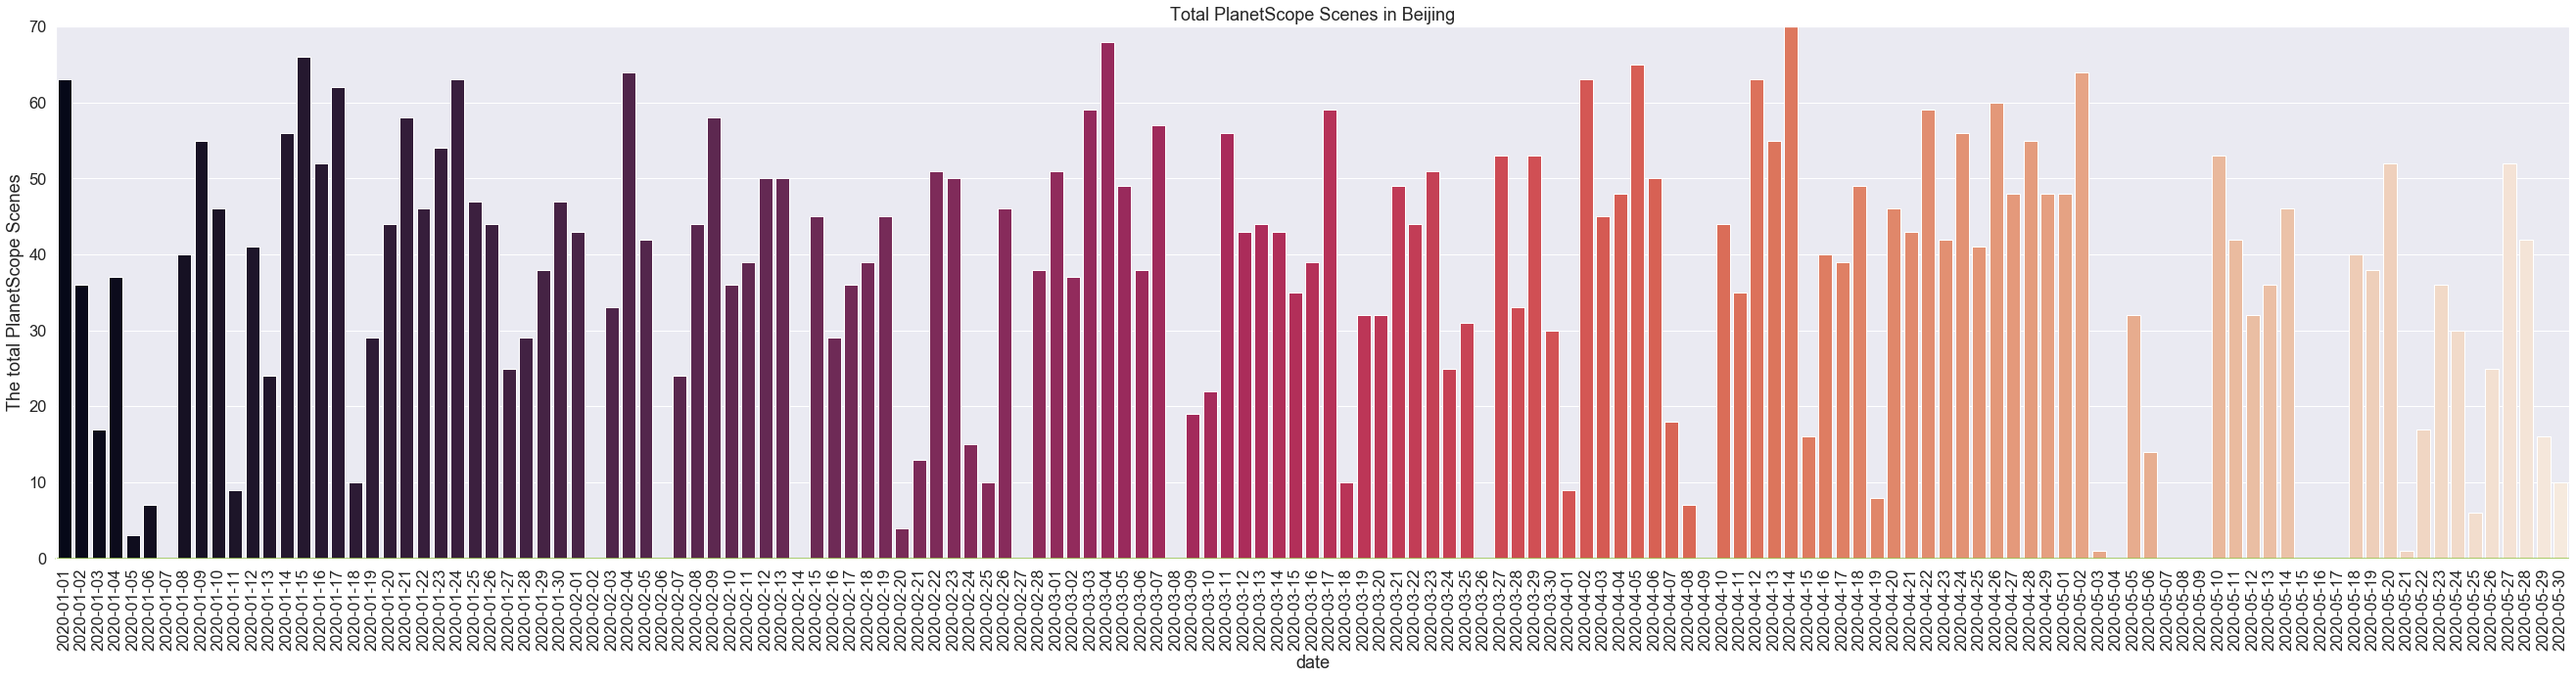

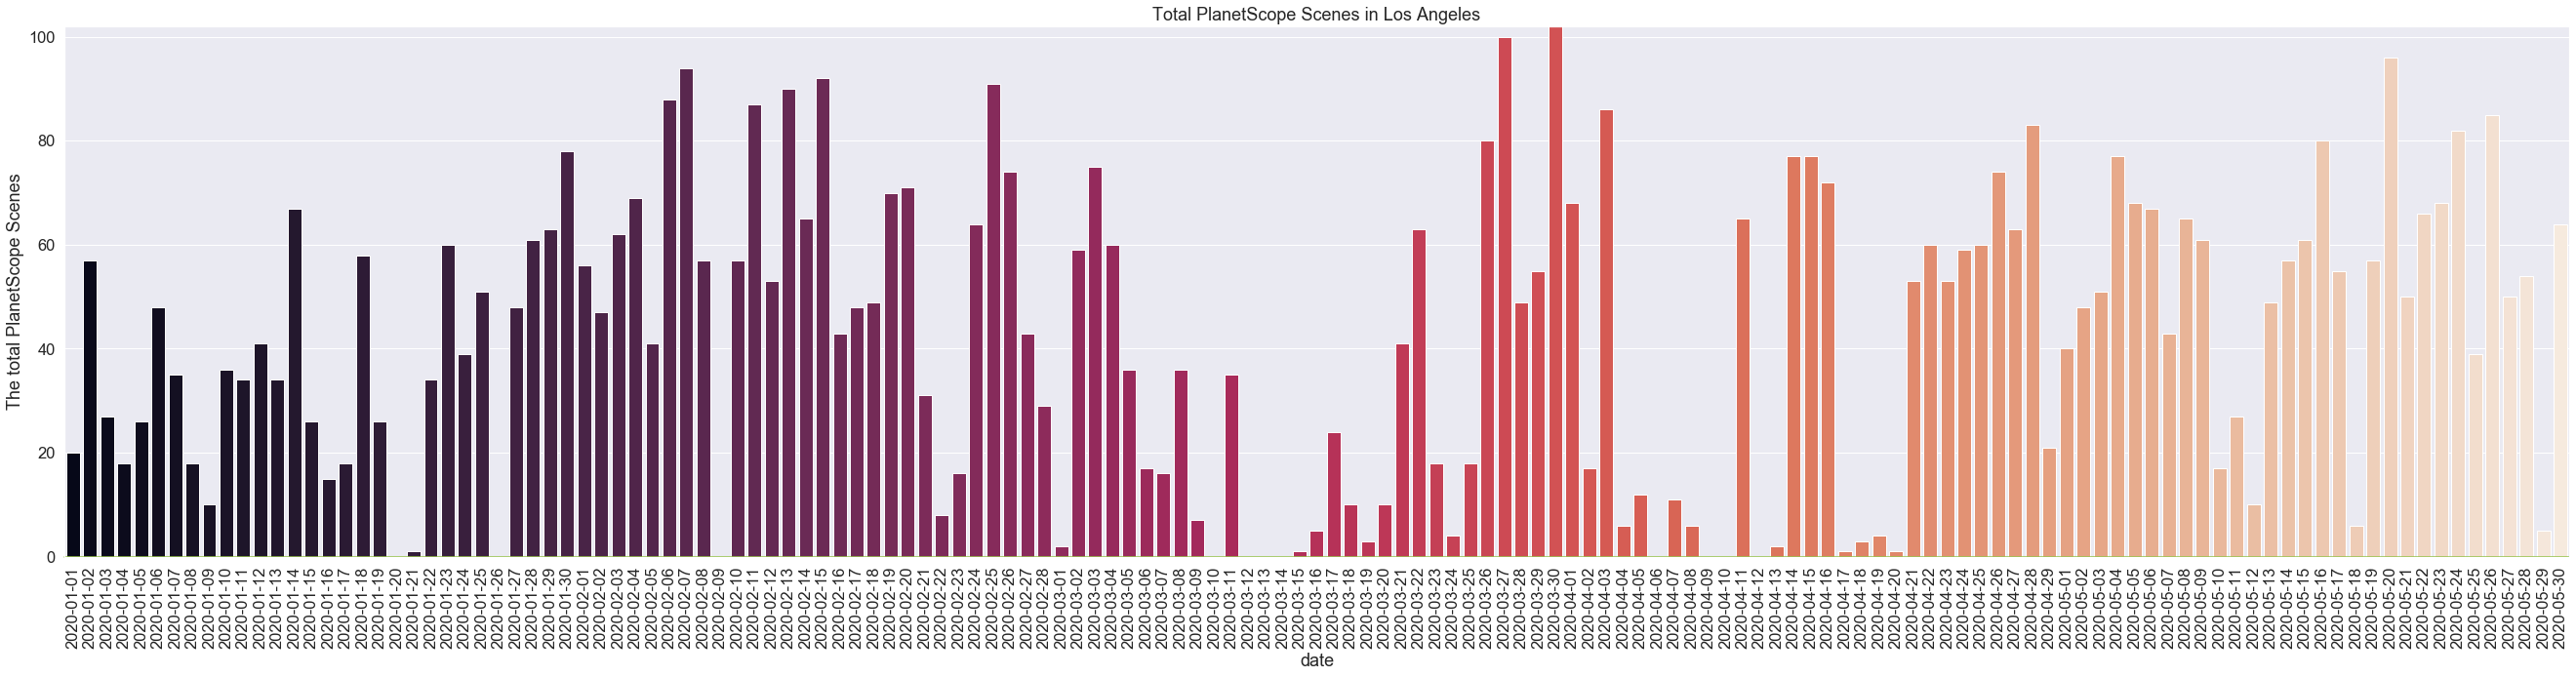

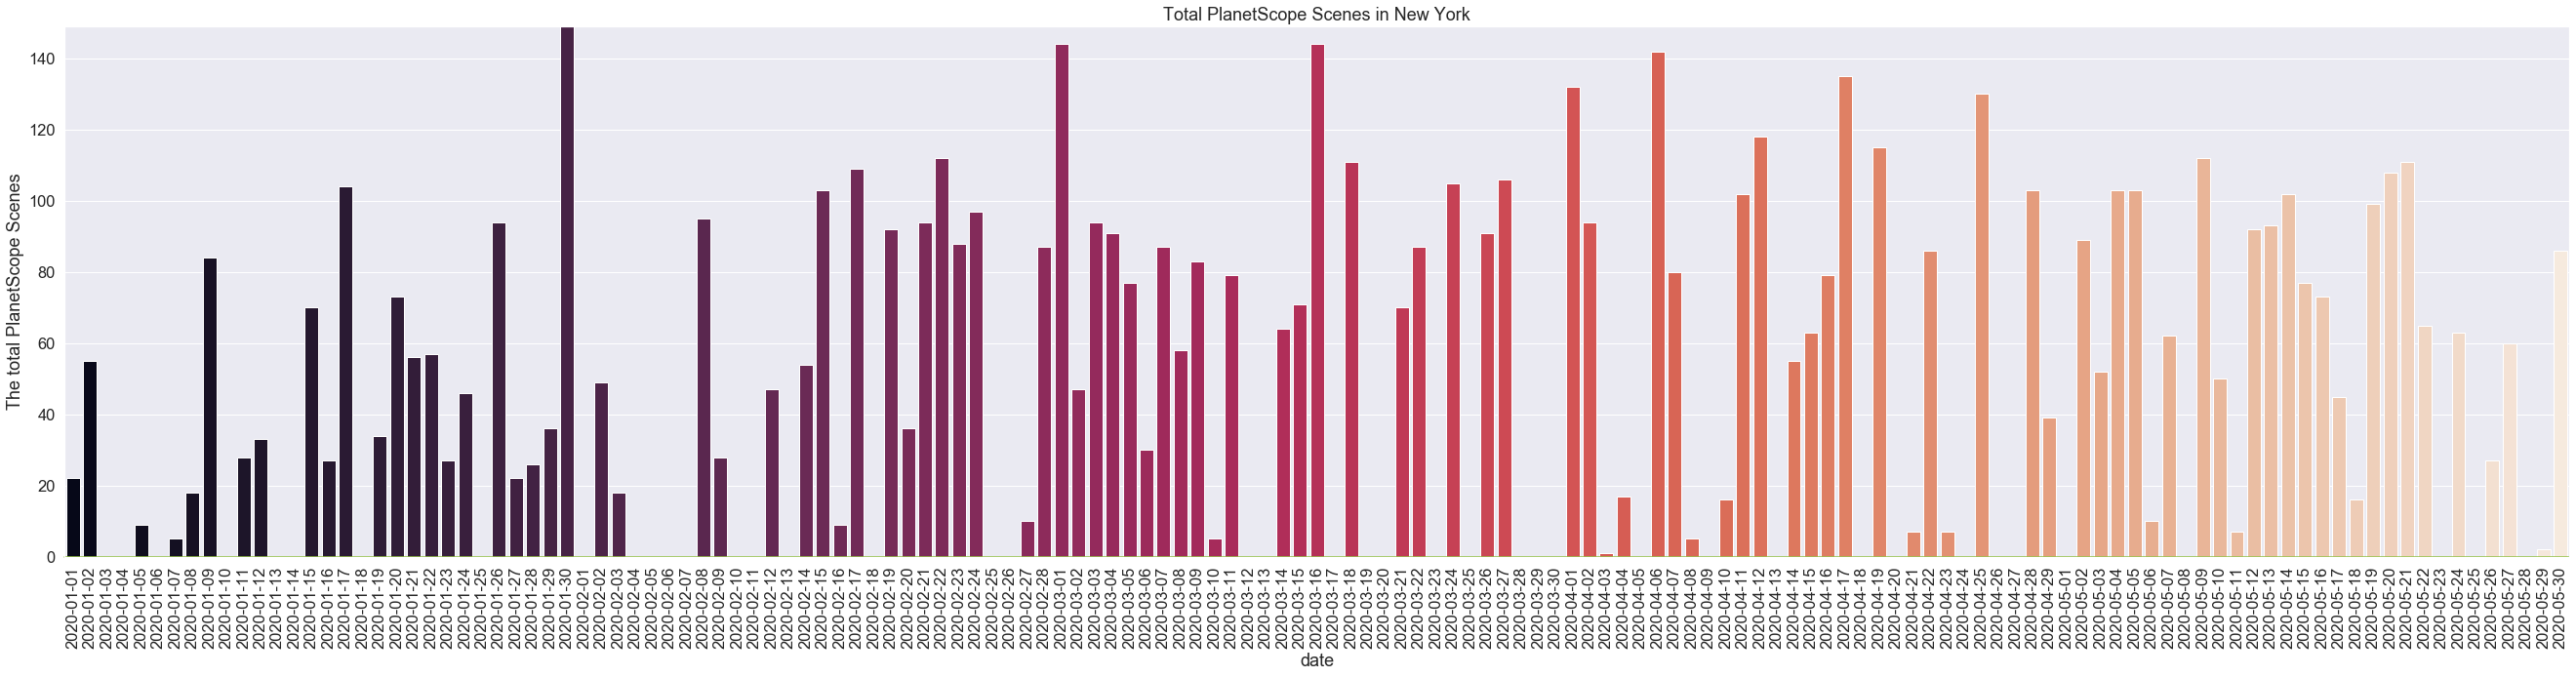

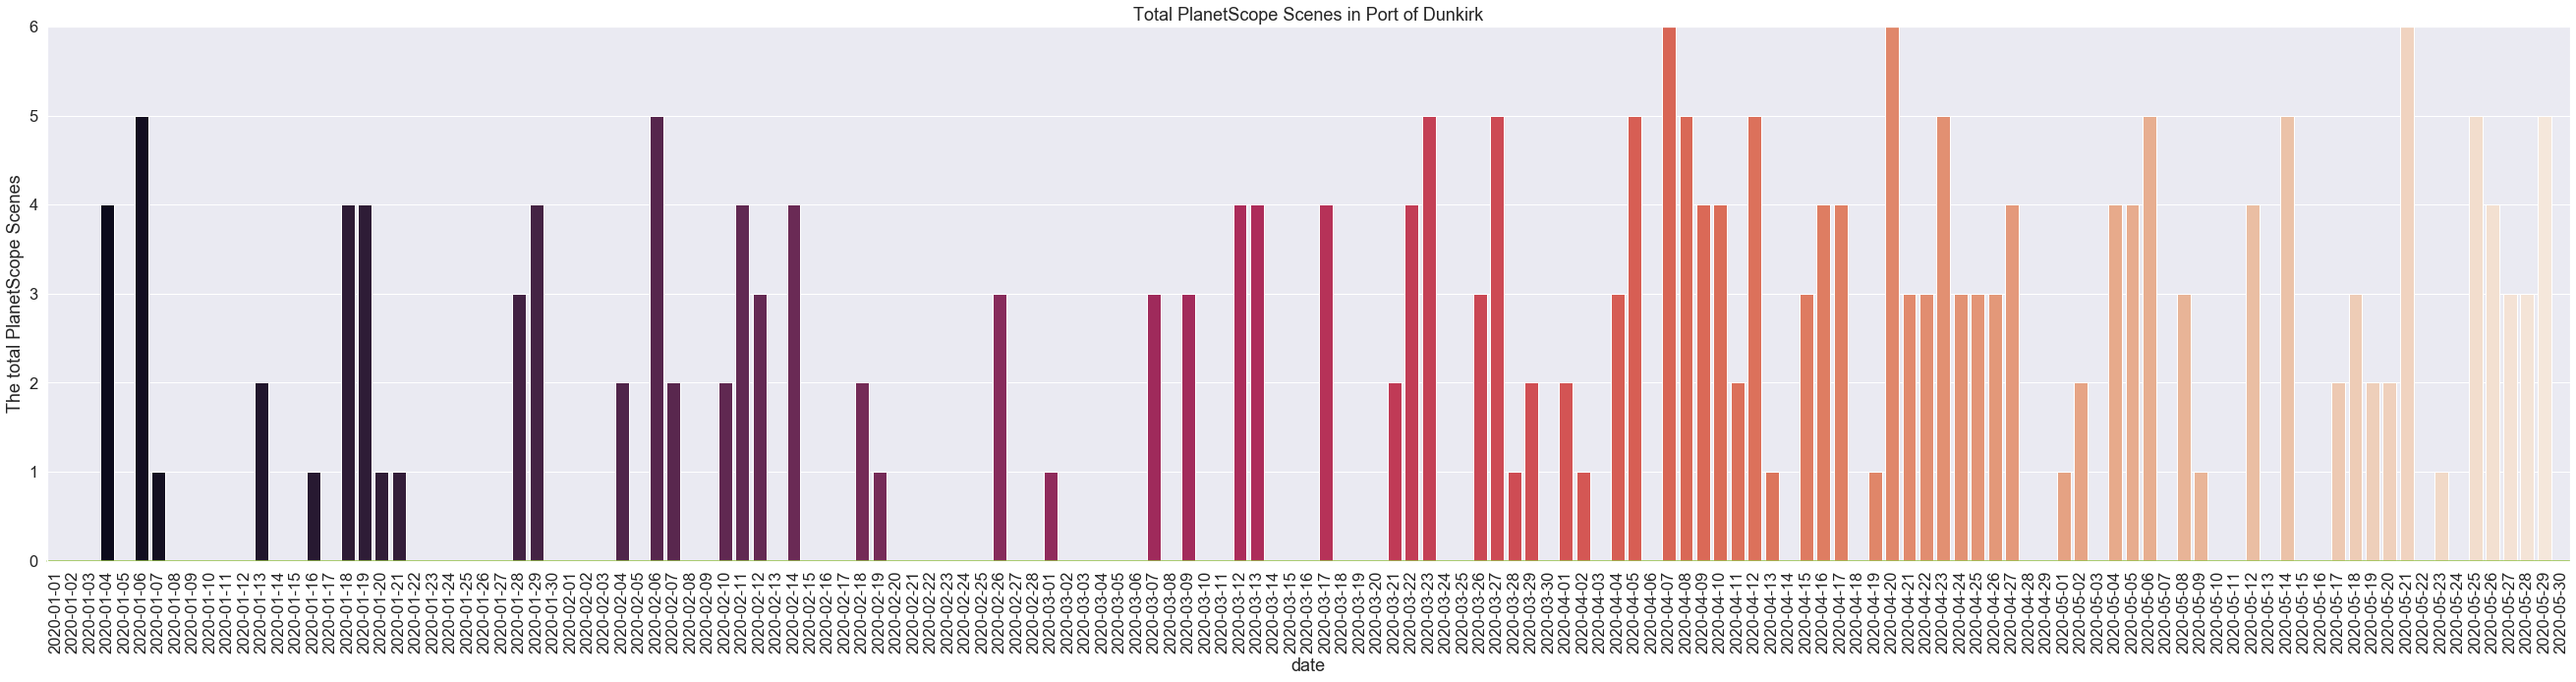

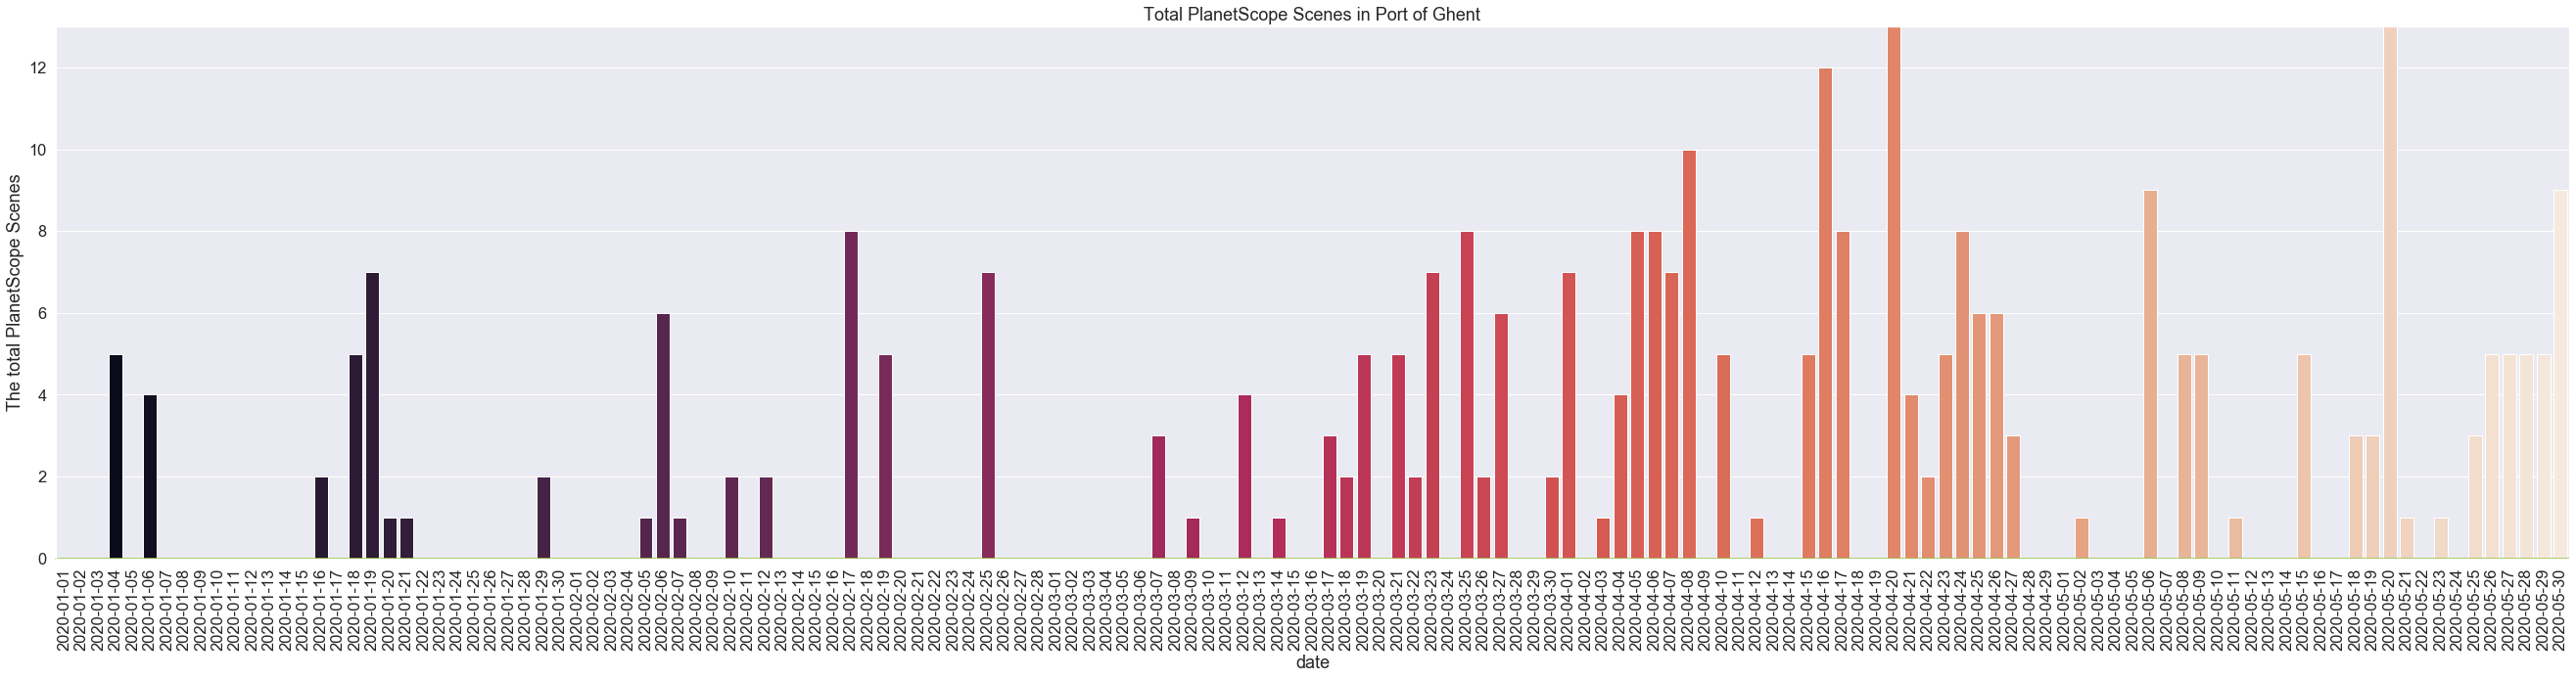

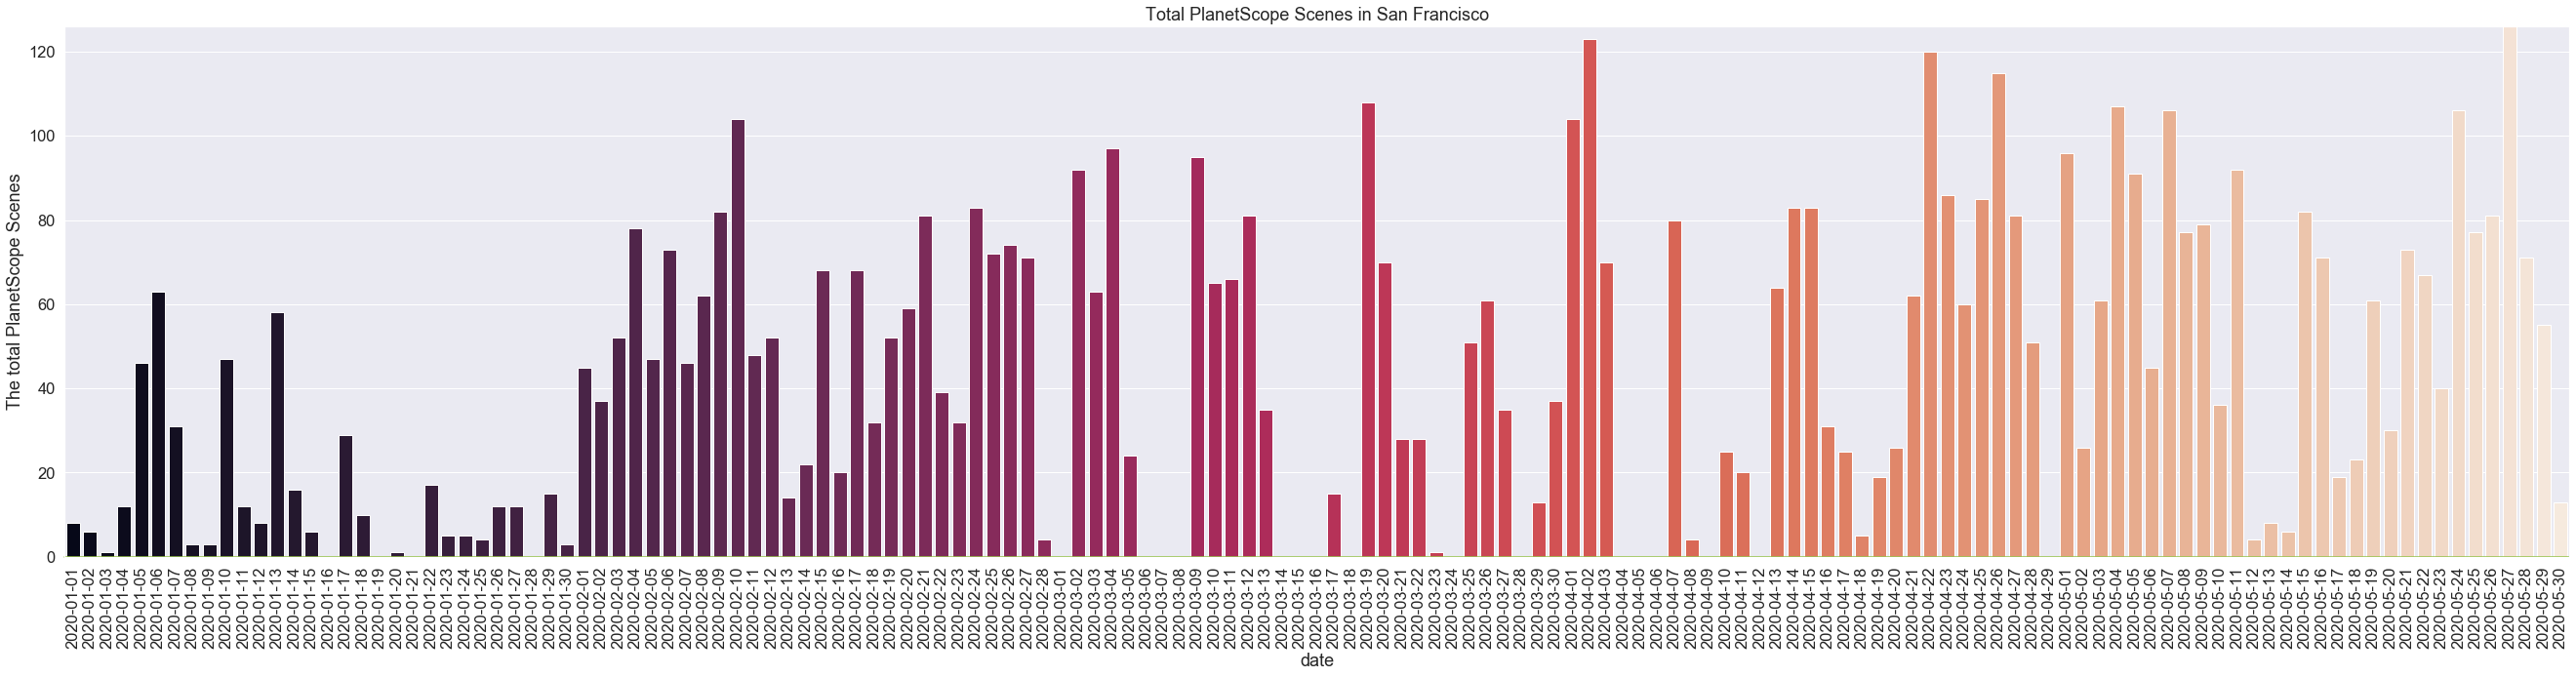

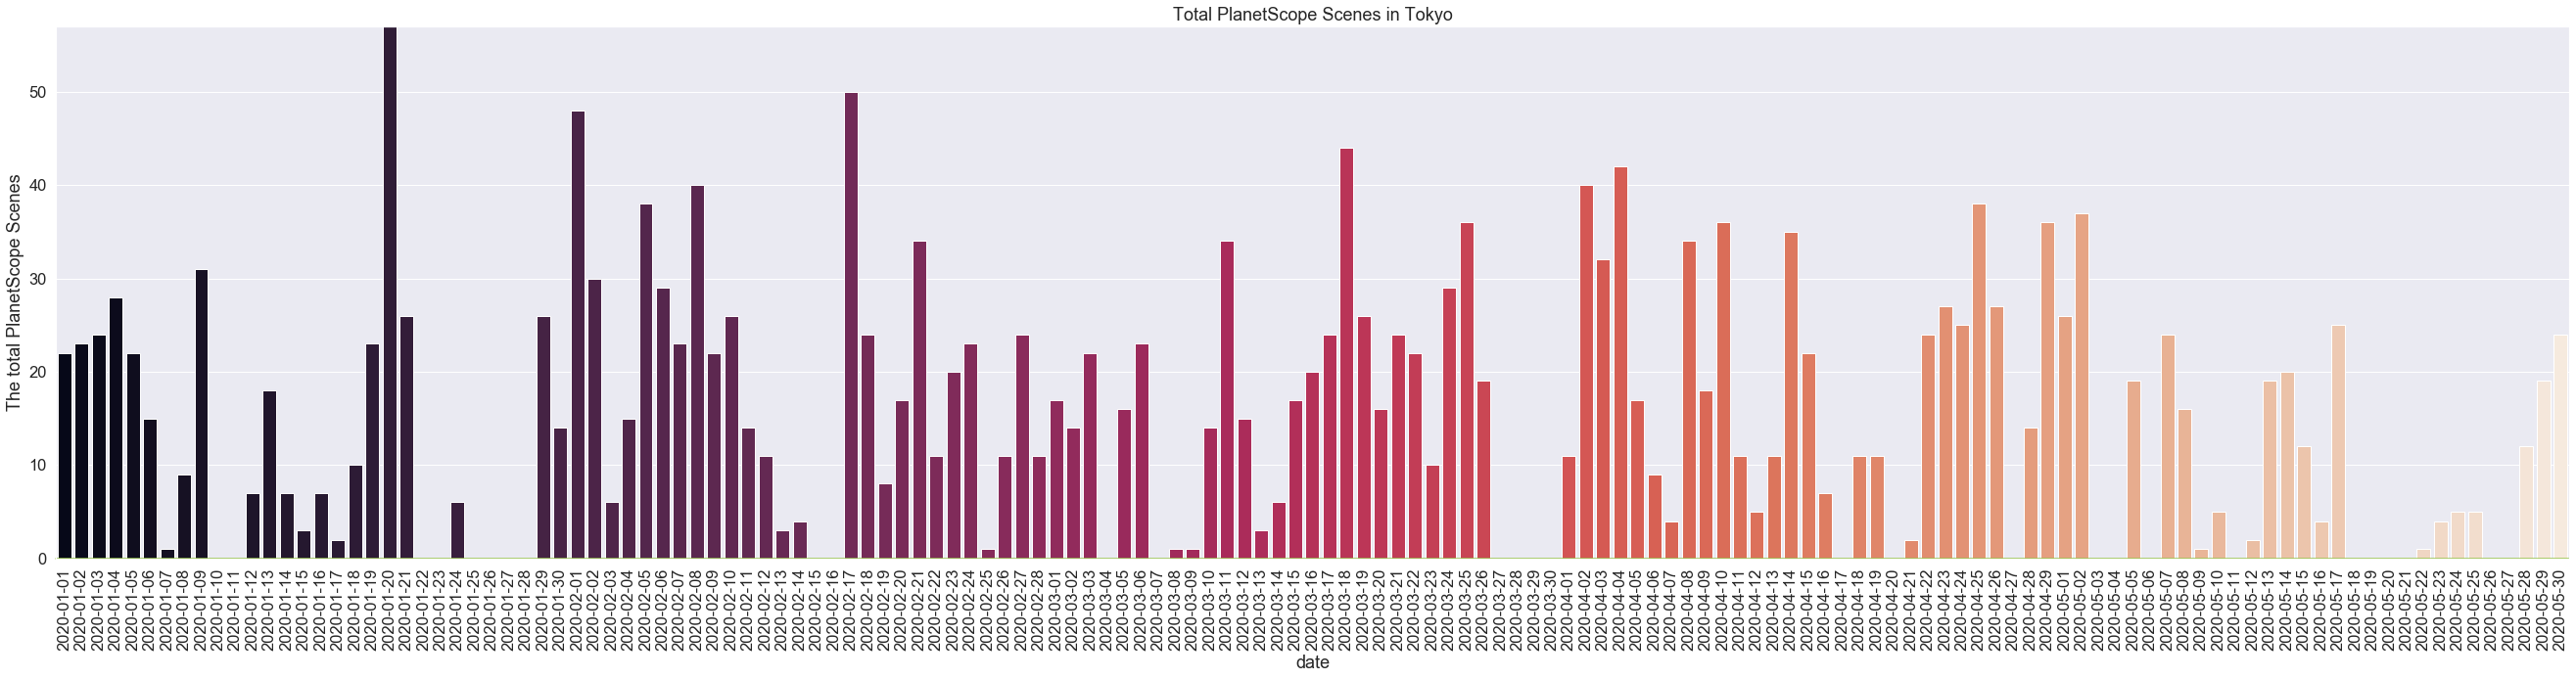

In [110]:
for aoi in AOIs:
    plot_pss_stas_aoi(aoi, all_pss_daily_sats)